# From_GAN_to_WGAN_Implementation

with Keras

In [63]:
from keras.models import *
from keras.layers import *
from keras.optimizers import*
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2,PIL

# 1. View MNIST DATASET (Just See)

In [7]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
X_train = X_train.astype(np.float32).reshape(-1, 28,28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28,28) / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [9]:
X_train = X_train[5000:]
X_valid = X_train[:5000]

y_train = y_train[5000:]
y_valid = y_train[:5000]


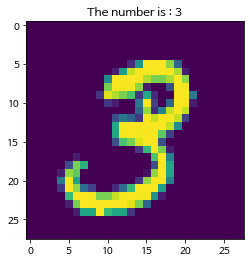

In [16]:
# Prints image
plt.rcParams['font.family'] = 'NanumBarunGothic'

plt.imshow(X_train[1])
plt.title("The number is : {0}".format(y_train[1]))
plt.show()

# 2. Build Network

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=4000, batch_size=32, sample_interval=50)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999909] [G loss: 1.000171]
1 [D loss: 0.999919] [G loss: 1.000168]
2 [D loss: 0.999919] [G loss: 1.000177]
3 [D loss: 0.999921] [G loss: 1.000172]
4 [D loss: 0.999924] [G loss: 1.000174]
5 [D loss: 0.999924] [G loss: 1.000180]
6 [D loss: 0.999924] [G loss: 1.000179]
7 [D loss: 0.999927] [G loss: 1.000171]
8 [D loss: 0.999921] [G loss: 1.000183]
9 [D loss: 0.999921] [G loss: 1.000190]
10 [D loss: 0.999926] [G loss: 1.000189]
11 [D loss: 0.999923] [G loss: 1.000180]
12 [D loss: 0.999922] [G loss: 1.000181]
13 [D loss: 0.999926] [G loss: 1.000186]
14 [D loss: 0.999925] [G loss: 1.000187]
15 [D loss: 0.999930] [G loss: 1.000197]
16 [D loss: 0.999928] [G loss: 1.000195]
17 [D loss: 0.999930] [G loss: 1.000198]
18 [D loss: 0.999932] [G loss: 1.000186]
19 [D loss: 0.999935] [G loss: 1.000190]
20 [D loss: 0.999939] [G loss: 1.000180]
21 [D loss: 0.999943] [G loss: 1.000160]
22 [D loss: 0.999936] [G loss: 1.000157]
23 [D loss: 0.999935] [G loss: 1.000147]
24 [D loss: 0.999947] [G l

198 [D loss: 0.999926] [G loss: 0.999989]
199 [D loss: 0.999923] [G loss: 1.000020]
200 [D loss: 0.999990] [G loss: 1.000042]
201 [D loss: 0.999965] [G loss: 1.000077]
202 [D loss: 0.999924] [G loss: 1.000052]
203 [D loss: 0.999978] [G loss: 1.000066]
204 [D loss: 1.000022] [G loss: 1.000025]
205 [D loss: 0.999900] [G loss: 1.000059]
206 [D loss: 0.999940] [G loss: 1.000069]
207 [D loss: 0.999959] [G loss: 1.000075]
208 [D loss: 0.999940] [G loss: 1.000017]
209 [D loss: 0.999970] [G loss: 1.000005]
210 [D loss: 0.999944] [G loss: 1.000104]
211 [D loss: 0.999936] [G loss: 1.000059]
212 [D loss: 0.999919] [G loss: 1.000024]
213 [D loss: 0.999969] [G loss: 1.000068]
214 [D loss: 0.999987] [G loss: 1.000026]
215 [D loss: 0.999938] [G loss: 0.999995]
216 [D loss: 0.999973] [G loss: 1.000052]
217 [D loss: 0.999943] [G loss: 1.000005]
218 [D loss: 0.999938] [G loss: 1.000020]
219 [D loss: 1.000023] [G loss: 1.000043]
220 [D loss: 0.999941] [G loss: 1.000069]
221 [D loss: 0.999906] [G loss: 1.

394 [D loss: 0.999950] [G loss: 1.000021]
395 [D loss: 0.999965] [G loss: 1.000069]
396 [D loss: 0.999968] [G loss: 1.000051]
397 [D loss: 0.999957] [G loss: 1.000013]
398 [D loss: 0.999945] [G loss: 1.000092]
399 [D loss: 0.999928] [G loss: 1.000018]
400 [D loss: 0.999972] [G loss: 1.000033]
401 [D loss: 0.999964] [G loss: 1.000060]
402 [D loss: 0.999974] [G loss: 1.000032]
403 [D loss: 0.999944] [G loss: 1.000039]
404 [D loss: 0.999909] [G loss: 1.000082]
405 [D loss: 0.999936] [G loss: 1.000085]
406 [D loss: 0.999947] [G loss: 1.000056]
407 [D loss: 0.999955] [G loss: 1.000050]
408 [D loss: 0.999975] [G loss: 1.000013]
409 [D loss: 0.999970] [G loss: 1.000063]
410 [D loss: 0.999957] [G loss: 0.999998]
411 [D loss: 0.999919] [G loss: 1.000062]
412 [D loss: 0.999948] [G loss: 1.000082]
413 [D loss: 0.999936] [G loss: 1.000036]
414 [D loss: 0.999959] [G loss: 0.999995]
415 [D loss: 0.999959] [G loss: 1.000046]
416 [D loss: 0.999982] [G loss: 1.000095]
417 [D loss: 1.000001] [G loss: 1.

590 [D loss: 0.999931] [G loss: 1.000055]
591 [D loss: 0.999909] [G loss: 1.000033]
592 [D loss: 0.999948] [G loss: 1.000065]
593 [D loss: 0.999941] [G loss: 1.000021]
594 [D loss: 0.999933] [G loss: 1.000050]
595 [D loss: 0.999939] [G loss: 1.000063]
596 [D loss: 0.999942] [G loss: 1.000042]
597 [D loss: 0.999942] [G loss: 1.000002]
598 [D loss: 0.999952] [G loss: 0.999981]
599 [D loss: 0.999930] [G loss: 1.000082]
600 [D loss: 0.999938] [G loss: 1.000014]
601 [D loss: 0.999953] [G loss: 1.000021]
602 [D loss: 0.999929] [G loss: 1.000074]
603 [D loss: 0.999939] [G loss: 1.000077]
604 [D loss: 0.999950] [G loss: 1.000039]
605 [D loss: 0.999982] [G loss: 1.000062]
606 [D loss: 0.999969] [G loss: 1.000048]
607 [D loss: 0.999943] [G loss: 1.000097]
608 [D loss: 0.999970] [G loss: 1.000061]
609 [D loss: 0.999970] [G loss: 1.000006]
610 [D loss: 0.999957] [G loss: 1.000060]
611 [D loss: 0.999943] [G loss: 1.000044]
612 [D loss: 0.999934] [G loss: 1.000085]
613 [D loss: 0.999960] [G loss: 1.

786 [D loss: 0.999971] [G loss: 1.000063]
787 [D loss: 0.999985] [G loss: 1.000053]
788 [D loss: 0.999931] [G loss: 1.000071]
789 [D loss: 0.999987] [G loss: 1.000031]
790 [D loss: 0.999954] [G loss: 1.000047]
791 [D loss: 0.999930] [G loss: 1.000019]
792 [D loss: 0.999967] [G loss: 1.000029]
793 [D loss: 0.999939] [G loss: 1.000040]
794 [D loss: 0.999924] [G loss: 1.000056]
795 [D loss: 0.999970] [G loss: 1.000016]
796 [D loss: 0.999930] [G loss: 1.000055]
797 [D loss: 0.999969] [G loss: 1.000037]
798 [D loss: 0.999950] [G loss: 1.000058]
799 [D loss: 0.999935] [G loss: 1.000059]
800 [D loss: 0.999967] [G loss: 1.000064]
801 [D loss: 0.999963] [G loss: 0.999983]
802 [D loss: 0.999982] [G loss: 1.000054]
803 [D loss: 0.999969] [G loss: 1.000053]
804 [D loss: 0.999965] [G loss: 1.000089]
805 [D loss: 0.999981] [G loss: 1.000063]
806 [D loss: 0.999965] [G loss: 1.000057]
807 [D loss: 0.999975] [G loss: 1.000094]
808 [D loss: 0.999923] [G loss: 1.000061]
809 [D loss: 0.999963] [G loss: 1.

982 [D loss: 0.999926] [G loss: 0.999996]
983 [D loss: 0.999958] [G loss: 1.000013]
984 [D loss: 0.999910] [G loss: 1.000073]
985 [D loss: 0.999922] [G loss: 1.000050]
986 [D loss: 0.999905] [G loss: 1.000033]
987 [D loss: 0.999972] [G loss: 1.000116]
988 [D loss: 0.999912] [G loss: 1.000045]
989 [D loss: 0.999904] [G loss: 1.000047]
990 [D loss: 0.999937] [G loss: 0.999981]
991 [D loss: 0.999945] [G loss: 1.000028]
992 [D loss: 0.999946] [G loss: 1.000070]
993 [D loss: 0.999953] [G loss: 1.000067]
994 [D loss: 0.999943] [G loss: 0.999995]
995 [D loss: 0.999945] [G loss: 1.000084]
996 [D loss: 0.999940] [G loss: 0.999977]
997 [D loss: 0.999917] [G loss: 1.000020]
998 [D loss: 0.999961] [G loss: 0.999979]
999 [D loss: 0.999936] [G loss: 1.000057]
1000 [D loss: 0.999940] [G loss: 1.000055]
1001 [D loss: 0.999938] [G loss: 1.000039]
1002 [D loss: 0.999994] [G loss: 1.000009]
1003 [D loss: 0.999921] [G loss: 1.000062]
1004 [D loss: 0.999982] [G loss: 1.000018]
1005 [D loss: 0.999894] [G lo

1173 [D loss: 0.999917] [G loss: 1.000053]
1174 [D loss: 0.999904] [G loss: 0.999980]
1175 [D loss: 0.999955] [G loss: 1.000014]
1176 [D loss: 0.999901] [G loss: 0.999974]
1177 [D loss: 0.999959] [G loss: 1.000029]
1178 [D loss: 0.999918] [G loss: 1.000060]
1179 [D loss: 0.999941] [G loss: 0.999998]
1180 [D loss: 0.999925] [G loss: 1.000016]
1181 [D loss: 0.999926] [G loss: 1.000041]
1182 [D loss: 0.999953] [G loss: 0.999910]
1183 [D loss: 0.999934] [G loss: 1.000035]
1184 [D loss: 0.999912] [G loss: 0.999917]
1185 [D loss: 0.999976] [G loss: 1.000053]
1186 [D loss: 0.999906] [G loss: 0.999982]
1187 [D loss: 0.999938] [G loss: 1.000145]
1188 [D loss: 0.999905] [G loss: 1.000030]
1189 [D loss: 0.999964] [G loss: 1.000099]
1190 [D loss: 0.999900] [G loss: 1.000139]
1191 [D loss: 0.999897] [G loss: 1.000037]
1192 [D loss: 0.999970] [G loss: 1.000026]
1193 [D loss: 0.999939] [G loss: 0.999914]
1194 [D loss: 0.999988] [G loss: 1.000018]
1195 [D loss: 0.999946] [G loss: 0.999929]
1196 [D los

1364 [D loss: 0.999786] [G loss: 0.999923]
1365 [D loss: 0.999849] [G loss: 1.000060]
1366 [D loss: 0.999850] [G loss: 0.999918]
1367 [D loss: 0.999889] [G loss: 0.999981]
1368 [D loss: 0.999851] [G loss: 0.999842]
1369 [D loss: 0.999858] [G loss: 1.000082]
1370 [D loss: 0.999997] [G loss: 0.999972]
1371 [D loss: 0.999902] [G loss: 0.999784]
1372 [D loss: 0.999812] [G loss: 0.999955]
1373 [D loss: 0.999956] [G loss: 1.000128]
1374 [D loss: 0.999926] [G loss: 0.999977]
1375 [D loss: 0.999835] [G loss: 0.999858]
1376 [D loss: 0.999953] [G loss: 1.000078]
1377 [D loss: 0.999890] [G loss: 0.999939]
1378 [D loss: 0.999821] [G loss: 1.000067]
1379 [D loss: 0.999833] [G loss: 1.000048]
1380 [D loss: 0.999888] [G loss: 1.000082]
1381 [D loss: 1.000021] [G loss: 1.000018]
1382 [D loss: 0.999842] [G loss: 0.999900]
1383 [D loss: 0.999871] [G loss: 0.999928]
1384 [D loss: 1.000047] [G loss: 1.000083]
1385 [D loss: 0.999828] [G loss: 0.999884]
1386 [D loss: 0.999860] [G loss: 0.999977]
1387 [D los

1555 [D loss: 0.999810] [G loss: 0.999883]
1556 [D loss: 1.000032] [G loss: 0.999956]
1557 [D loss: 0.999926] [G loss: 1.000024]
1558 [D loss: 0.999953] [G loss: 0.999868]
1559 [D loss: 0.999924] [G loss: 0.999990]
1560 [D loss: 0.999953] [G loss: 1.000037]
1561 [D loss: 0.999904] [G loss: 1.000020]
1562 [D loss: 0.999852] [G loss: 0.999964]
1563 [D loss: 0.999907] [G loss: 1.000076]
1564 [D loss: 0.999828] [G loss: 1.000040]
1565 [D loss: 0.999932] [G loss: 1.000005]
1566 [D loss: 0.999921] [G loss: 0.999801]
1567 [D loss: 0.999882] [G loss: 0.999934]
1568 [D loss: 1.000007] [G loss: 0.999983]
1569 [D loss: 0.999835] [G loss: 1.000093]
1570 [D loss: 0.999971] [G loss: 0.999977]
1571 [D loss: 0.999868] [G loss: 1.000003]
1572 [D loss: 1.000023] [G loss: 1.000054]
1573 [D loss: 0.999966] [G loss: 1.000053]
1574 [D loss: 0.999917] [G loss: 1.000099]
1575 [D loss: 0.999991] [G loss: 1.000028]
1576 [D loss: 1.000026] [G loss: 1.000036]
1577 [D loss: 0.999907] [G loss: 1.000033]
1578 [D los

1746 [D loss: 0.999982] [G loss: 1.000079]
1747 [D loss: 0.999966] [G loss: 1.000095]
1748 [D loss: 0.999875] [G loss: 1.000047]
1749 [D loss: 0.999941] [G loss: 0.999998]
1750 [D loss: 0.999945] [G loss: 0.999990]
1751 [D loss: 0.999892] [G loss: 0.999917]
1752 [D loss: 0.999886] [G loss: 0.999972]
1753 [D loss: 1.000005] [G loss: 1.000049]
1754 [D loss: 0.999934] [G loss: 1.000035]
1755 [D loss: 0.999950] [G loss: 0.999981]
1756 [D loss: 0.999986] [G loss: 1.000117]
1757 [D loss: 0.999935] [G loss: 0.999998]
1758 [D loss: 0.999945] [G loss: 0.999976]
1759 [D loss: 0.999948] [G loss: 1.000002]
1760 [D loss: 0.999917] [G loss: 1.000032]
1761 [D loss: 0.999938] [G loss: 1.000023]
1762 [D loss: 0.999906] [G loss: 1.000090]
1763 [D loss: 0.999948] [G loss: 0.999995]
1764 [D loss: 0.999975] [G loss: 1.000034]
1765 [D loss: 0.999881] [G loss: 1.000152]
1766 [D loss: 0.999915] [G loss: 0.999918]
1767 [D loss: 1.000008] [G loss: 1.000031]
1768 [D loss: 0.999931] [G loss: 1.000069]
1769 [D los

1937 [D loss: 0.999811] [G loss: 0.999883]
1938 [D loss: 0.999885] [G loss: 0.999953]
1939 [D loss: 0.999938] [G loss: 1.000070]
1940 [D loss: 0.999907] [G loss: 1.000046]
1941 [D loss: 0.999846] [G loss: 1.000092]
1942 [D loss: 1.000007] [G loss: 1.000015]
1943 [D loss: 0.999915] [G loss: 1.000007]
1944 [D loss: 0.999953] [G loss: 0.999995]
1945 [D loss: 0.999893] [G loss: 1.000024]
1946 [D loss: 0.999926] [G loss: 1.000082]
1947 [D loss: 0.999936] [G loss: 1.000053]
1948 [D loss: 0.999962] [G loss: 0.999965]
1949 [D loss: 0.999958] [G loss: 1.000103]
1950 [D loss: 0.999964] [G loss: 1.000149]
1951 [D loss: 0.999841] [G loss: 1.000068]
1952 [D loss: 0.999979] [G loss: 0.999995]
1953 [D loss: 0.999970] [G loss: 1.000085]
1954 [D loss: 0.999895] [G loss: 0.999980]
1955 [D loss: 0.999943] [G loss: 1.000020]
1956 [D loss: 0.999926] [G loss: 0.999994]
1957 [D loss: 0.999914] [G loss: 0.999918]
1958 [D loss: 0.999884] [G loss: 0.999882]
1959 [D loss: 0.999941] [G loss: 0.999954]
1960 [D los

2128 [D loss: 0.999899] [G loss: 0.999868]
2129 [D loss: 0.999926] [G loss: 0.999811]
2130 [D loss: 0.999899] [G loss: 1.000115]
2131 [D loss: 0.999806] [G loss: 1.000014]
2132 [D loss: 0.999934] [G loss: 0.999772]
2133 [D loss: 0.999843] [G loss: 0.999991]
2134 [D loss: 0.999910] [G loss: 0.999921]
2135 [D loss: 0.999888] [G loss: 1.000078]
2136 [D loss: 0.999868] [G loss: 0.999992]
2137 [D loss: 0.999813] [G loss: 1.000171]
2138 [D loss: 0.999857] [G loss: 0.999990]
2139 [D loss: 0.999840] [G loss: 0.999957]
2140 [D loss: 0.999913] [G loss: 1.000003]
2141 [D loss: 0.999928] [G loss: 0.999963]
2142 [D loss: 0.999955] [G loss: 1.000002]
2143 [D loss: 0.999833] [G loss: 1.000130]
2144 [D loss: 0.999939] [G loss: 1.000056]
2145 [D loss: 0.999885] [G loss: 0.999958]
2146 [D loss: 0.999829] [G loss: 0.999985]
2147 [D loss: 0.999906] [G loss: 0.999963]
2148 [D loss: 0.999850] [G loss: 1.000030]
2149 [D loss: 0.999892] [G loss: 1.000049]
2150 [D loss: 0.999767] [G loss: 0.999950]
2151 [D los

2319 [D loss: 1.000015] [G loss: 0.999977]
2320 [D loss: 0.999872] [G loss: 0.999949]
2321 [D loss: 0.999717] [G loss: 1.000081]
2322 [D loss: 0.999835] [G loss: 1.000037]
2323 [D loss: 0.999860] [G loss: 0.999788]
2324 [D loss: 0.999836] [G loss: 0.999928]
2325 [D loss: 0.999758] [G loss: 0.999961]
2326 [D loss: 0.999748] [G loss: 0.999923]
2327 [D loss: 0.999833] [G loss: 1.000090]
2328 [D loss: 0.999923] [G loss: 0.999863]
2329 [D loss: 0.999997] [G loss: 1.000023]
2330 [D loss: 0.999872] [G loss: 1.000083]
2331 [D loss: 0.999933] [G loss: 1.000157]
2332 [D loss: 0.999921] [G loss: 0.999905]
2333 [D loss: 0.999885] [G loss: 0.999911]
2334 [D loss: 0.999888] [G loss: 0.999982]
2335 [D loss: 0.999835] [G loss: 0.999987]
2336 [D loss: 0.999962] [G loss: 1.000045]
2337 [D loss: 0.999847] [G loss: 0.999919]
2338 [D loss: 0.999891] [G loss: 1.000030]
2339 [D loss: 0.999921] [G loss: 1.000057]
2340 [D loss: 0.999886] [G loss: 0.999998]
2341 [D loss: 0.999886] [G loss: 0.999973]
2342 [D los

2510 [D loss: 0.999878] [G loss: 1.000001]
2511 [D loss: 1.000047] [G loss: 1.000031]
2512 [D loss: 0.999937] [G loss: 1.000027]
2513 [D loss: 0.999911] [G loss: 1.000004]
2514 [D loss: 0.999821] [G loss: 1.000186]
2515 [D loss: 0.999815] [G loss: 1.000151]
2516 [D loss: 0.999983] [G loss: 0.999933]
2517 [D loss: 0.999824] [G loss: 0.999945]
2518 [D loss: 0.999918] [G loss: 0.999993]
2519 [D loss: 0.999842] [G loss: 1.000069]
2520 [D loss: 0.999829] [G loss: 1.000062]
2521 [D loss: 0.999867] [G loss: 0.999852]
2522 [D loss: 0.999934] [G loss: 0.999971]
2523 [D loss: 0.999952] [G loss: 0.999890]
2524 [D loss: 0.999960] [G loss: 0.999959]
2525 [D loss: 0.999921] [G loss: 1.000056]
2526 [D loss: 0.999911] [G loss: 0.999872]
2527 [D loss: 0.999846] [G loss: 0.999953]
2528 [D loss: 1.000030] [G loss: 1.000057]
2529 [D loss: 0.999848] [G loss: 0.999950]
2530 [D loss: 0.999832] [G loss: 1.000039]
2531 [D loss: 0.999893] [G loss: 1.000228]
2532 [D loss: 0.999932] [G loss: 1.000061]
2533 [D los

2701 [D loss: 0.999973] [G loss: 1.000079]
2702 [D loss: 0.999888] [G loss: 0.999947]
2703 [D loss: 0.999922] [G loss: 1.000000]
2704 [D loss: 0.999989] [G loss: 0.999956]
2705 [D loss: 0.999969] [G loss: 1.000011]
2706 [D loss: 0.999884] [G loss: 1.000128]
2707 [D loss: 0.999942] [G loss: 1.000121]
2708 [D loss: 0.999897] [G loss: 1.000083]
2709 [D loss: 0.999915] [G loss: 0.999924]
2710 [D loss: 0.999958] [G loss: 1.000055]
2711 [D loss: 0.999936] [G loss: 1.000049]
2712 [D loss: 0.999912] [G loss: 0.999854]
2713 [D loss: 0.999882] [G loss: 1.000055]
2714 [D loss: 0.999940] [G loss: 0.999944]
2715 [D loss: 0.999935] [G loss: 0.999972]
2716 [D loss: 0.999934] [G loss: 1.000006]
2717 [D loss: 0.999869] [G loss: 0.999997]
2718 [D loss: 1.000031] [G loss: 1.000049]
2719 [D loss: 0.999867] [G loss: 0.999994]
2720 [D loss: 0.999855] [G loss: 0.999852]
2721 [D loss: 0.999918] [G loss: 0.999925]
2722 [D loss: 0.999911] [G loss: 0.999944]
2723 [D loss: 0.999990] [G loss: 0.999966]
2724 [D los

2892 [D loss: 0.999855] [G loss: 1.000108]
2893 [D loss: 0.999952] [G loss: 1.000023]
2894 [D loss: 0.999856] [G loss: 1.000038]
2895 [D loss: 0.999792] [G loss: 1.000090]
2896 [D loss: 0.999834] [G loss: 0.999875]
2897 [D loss: 0.999931] [G loss: 0.999810]
2898 [D loss: 0.999905] [G loss: 0.999913]
2899 [D loss: 0.999864] [G loss: 0.999884]
2900 [D loss: 0.999861] [G loss: 1.000005]
2901 [D loss: 0.999817] [G loss: 0.999891]
2902 [D loss: 0.999885] [G loss: 0.999986]
2903 [D loss: 0.999932] [G loss: 1.000036]
2904 [D loss: 0.999949] [G loss: 0.999965]
2905 [D loss: 0.999976] [G loss: 0.999865]
2906 [D loss: 0.999891] [G loss: 0.999909]
2907 [D loss: 0.999781] [G loss: 1.000089]
2908 [D loss: 0.999940] [G loss: 0.999897]
2909 [D loss: 0.999878] [G loss: 0.999943]
2910 [D loss: 0.999938] [G loss: 1.000093]
2911 [D loss: 0.999839] [G loss: 0.999845]
2912 [D loss: 0.999794] [G loss: 0.999820]
2913 [D loss: 0.999887] [G loss: 0.999887]
2914 [D loss: 0.999792] [G loss: 0.999926]
2915 [D los

3083 [D loss: 0.999736] [G loss: 0.999848]
3084 [D loss: 0.999788] [G loss: 1.000009]
3085 [D loss: 0.999805] [G loss: 1.000045]
3086 [D loss: 0.999753] [G loss: 1.000120]
3087 [D loss: 0.999860] [G loss: 1.000070]
3088 [D loss: 1.000016] [G loss: 1.000178]
3089 [D loss: 0.999794] [G loss: 0.999826]
3090 [D loss: 0.999868] [G loss: 0.999736]
3091 [D loss: 0.999946] [G loss: 0.999727]
3092 [D loss: 0.999933] [G loss: 0.999948]
3093 [D loss: 0.999886] [G loss: 1.000033]
3094 [D loss: 0.999959] [G loss: 1.000092]
3095 [D loss: 0.999895] [G loss: 1.000017]
3096 [D loss: 0.999611] [G loss: 0.999883]
3097 [D loss: 0.999934] [G loss: 0.999868]
3098 [D loss: 0.999840] [G loss: 1.000069]
3099 [D loss: 0.999789] [G loss: 1.000010]
3100 [D loss: 0.999954] [G loss: 0.999925]
3101 [D loss: 1.000054] [G loss: 0.999955]
3102 [D loss: 0.999988] [G loss: 0.999898]
3103 [D loss: 0.999893] [G loss: 0.999709]
3104 [D loss: 0.999905] [G loss: 1.000066]
3105 [D loss: 0.999970] [G loss: 1.000017]
3106 [D los

3274 [D loss: 0.999877] [G loss: 0.999987]
3275 [D loss: 0.999905] [G loss: 1.000181]
3276 [D loss: 0.999946] [G loss: 1.000009]
3277 [D loss: 1.000049] [G loss: 0.999957]
3278 [D loss: 0.999807] [G loss: 0.999996]
3279 [D loss: 0.999903] [G loss: 1.000087]
3280 [D loss: 0.999842] [G loss: 1.000076]
3281 [D loss: 0.999888] [G loss: 1.000044]
3282 [D loss: 0.999872] [G loss: 0.999988]
3283 [D loss: 0.999940] [G loss: 1.000027]
3284 [D loss: 0.999967] [G loss: 1.000079]
3285 [D loss: 0.999830] [G loss: 1.000073]
3286 [D loss: 0.999889] [G loss: 1.000015]
3287 [D loss: 0.999874] [G loss: 1.000203]
3288 [D loss: 0.999788] [G loss: 1.000018]
3289 [D loss: 0.999765] [G loss: 1.000131]
3290 [D loss: 0.999814] [G loss: 1.000058]
3291 [D loss: 0.999925] [G loss: 1.000083]
3292 [D loss: 0.999875] [G loss: 1.000113]
3293 [D loss: 0.999924] [G loss: 1.000030]
3294 [D loss: 0.999892] [G loss: 1.000014]
3295 [D loss: 0.999878] [G loss: 0.999848]
3296 [D loss: 0.999959] [G loss: 0.999971]
3297 [D los

3465 [D loss: 0.999973] [G loss: 1.000012]
3466 [D loss: 1.000032] [G loss: 1.000040]
3467 [D loss: 0.999894] [G loss: 0.999935]
3468 [D loss: 0.999984] [G loss: 0.999932]
3469 [D loss: 0.999825] [G loss: 1.000073]
3470 [D loss: 0.999868] [G loss: 0.999937]
3471 [D loss: 0.999933] [G loss: 0.999978]
3472 [D loss: 0.999940] [G loss: 0.999952]
3473 [D loss: 0.999953] [G loss: 0.999982]
3474 [D loss: 0.999874] [G loss: 0.999917]
3475 [D loss: 0.999924] [G loss: 1.000003]
3476 [D loss: 0.999914] [G loss: 0.999992]
3477 [D loss: 0.999964] [G loss: 0.999968]
3478 [D loss: 1.000002] [G loss: 1.000092]
3479 [D loss: 0.999901] [G loss: 0.999968]
3480 [D loss: 0.999828] [G loss: 1.000055]
3481 [D loss: 0.999959] [G loss: 1.000110]
3482 [D loss: 0.999919] [G loss: 1.000142]
3483 [D loss: 0.999961] [G loss: 1.000051]
3484 [D loss: 0.999912] [G loss: 0.999975]
3485 [D loss: 1.000018] [G loss: 1.000014]
3486 [D loss: 0.999860] [G loss: 1.000086]
3487 [D loss: 0.999896] [G loss: 0.999934]
3488 [D los

3656 [D loss: 0.999970] [G loss: 0.999996]
3657 [D loss: 0.999925] [G loss: 1.000040]
3658 [D loss: 0.999976] [G loss: 0.999985]
3659 [D loss: 0.999943] [G loss: 1.000009]
3660 [D loss: 0.999987] [G loss: 0.999968]
3661 [D loss: 0.999947] [G loss: 1.000038]
3662 [D loss: 0.999980] [G loss: 1.000050]
3663 [D loss: 0.999939] [G loss: 1.000122]
3664 [D loss: 0.999958] [G loss: 0.999959]
3665 [D loss: 0.999944] [G loss: 1.000043]
3666 [D loss: 0.999922] [G loss: 1.000067]
3667 [D loss: 1.000000] [G loss: 1.000077]
3668 [D loss: 0.999887] [G loss: 1.000024]
3669 [D loss: 0.999952] [G loss: 1.000055]
3670 [D loss: 0.999996] [G loss: 1.000020]
3671 [D loss: 0.999916] [G loss: 1.000065]
3672 [D loss: 0.999888] [G loss: 0.999952]
3673 [D loss: 0.999970] [G loss: 1.000139]
3674 [D loss: 0.999900] [G loss: 1.000040]
3675 [D loss: 1.000005] [G loss: 1.000087]
3676 [D loss: 0.999934] [G loss: 0.999913]
3677 [D loss: 0.999909] [G loss: 0.999994]
3678 [D loss: 0.999983] [G loss: 1.000013]
3679 [D los

3847 [D loss: 0.999922] [G loss: 1.000047]
3848 [D loss: 0.999981] [G loss: 1.000027]
3849 [D loss: 0.999924] [G loss: 1.000010]
3850 [D loss: 0.999920] [G loss: 1.000069]
3851 [D loss: 0.999943] [G loss: 1.000041]
3852 [D loss: 0.999930] [G loss: 1.000026]
3853 [D loss: 0.999903] [G loss: 1.000052]
3854 [D loss: 0.999917] [G loss: 1.000085]
3855 [D loss: 0.999942] [G loss: 1.000090]
3856 [D loss: 0.999934] [G loss: 1.000100]
3857 [D loss: 0.999919] [G loss: 0.999993]
3858 [D loss: 0.999986] [G loss: 1.000063]
3859 [D loss: 0.999943] [G loss: 1.000007]
3860 [D loss: 0.999976] [G loss: 1.000053]
3861 [D loss: 0.999939] [G loss: 1.000082]
3862 [D loss: 0.999966] [G loss: 0.999970]
3863 [D loss: 0.999948] [G loss: 1.000081]
3864 [D loss: 0.999970] [G loss: 1.000037]
3865 [D loss: 0.999915] [G loss: 1.000083]
3866 [D loss: 0.999975] [G loss: 1.000052]
3867 [D loss: 0.999909] [G loss: 1.000059]
3868 [D loss: 0.999964] [G loss: 1.000035]
3869 [D loss: 0.999969] [G loss: 1.000038]
3870 [D los

In [177]:
import os
path2 = os.getcwd()
path2

'/Users/charming/Python/0_Paper_Review/08. From GAN to WGAN'

In [180]:
generated_image_array = [imageio.imread(generated_image) for generated_image in f]
imageio.mimsave(path + 'WGAN_MNIST2.gif', generated_image_array, fps=5)